In [1]:
#example for the Millersville group
#first we do a bunch of imports

In [30]:
import cartopy
import matplotlib.patheffects as mpatheffects
import matplotlib.pyplot as plt
import metpy.calc as mpcalc
from metpy.plots import simple_layout, StationPlot, StationPlotLayout
from metpy.plots.wx_symbols import sky_cover, current_weather
from metpy.units import units
import pytz
from siphon.catalog import TDSCatalog
from siphon.ncss import NCSS
from datetime import datetime, timedelta
import numpy as np
from scipy.spatial import cKDTree


%matplotlib inline


In [3]:
def _nearestDate(dates, pivot):
    return min(dates, key=lambda x: abs(x - pivot))



In [4]:
#WMO weather codes
wx_code_map = {'': 0, 'DU':7, 'BLDU':7, 'HZ': 5, 'BR': 10, '-UP':16, 'UP': 16, 'SQ': 18, 'FC': 19,
               'DRSN': 36, 'FG': 45, 'FZFG': 49, '-DZ': 51, 'DZ': 53, '+DZ': 55,
               '-RA': 61, 'RA': 63, '+RA': 65, '-FZRA': 66,
               '-SN': 71, 'SN': 73, '+SN': 75, '-SHRA': 80, 'SHRA': 81, '-SHSN': 85,
               '-TSRA' : 95, '+TSRA':97, 'TSRA':95, 'VCTSRA': 92 }

def to_code(text):
    for s in text:
        if ' ' in s:
            yield max(to_code(s.split()))
        else:
            yield wx_code_map[s]


In [18]:

def thin_points(xy, radius, sort_key=None):
    # All points masked initially
    mask = np.ones(xy.shape[0], dtype=np.bool)

    if sort_key is not None:
        # Need in decreasing priority
        sorted_indices = np.argsort(sort_key)[::-1]
    else:
        sorted_indices = np.arange(len(xy))

    # Make our tree
    tree = cKDTree(xy)

    # Loop over all the potential points
    for sort_ind in sorted_indices:
        val = mask[sort_ind]
        # Only proceed if we haven't already excluded this point
        if val:
            # Loop over all the neighbors within the radius
            for neighbor in tree.query_ball_point(xy[sort_ind], radius):
                # Mask them out, but don't mask ourselves
                if neighbor != sort_ind:
                    mask[neighbor] = False

    return mask


In [19]:
def filter_data(data_dict, projection, radius=100000, sort_key=None, bbox=None):
    'Reduce station density and remove stations outside given bounding box.'
    # Pull location information from our data dictionary
    lats = data_dict['latitude'][:]
    lons = data_dict['longitude'][:]

    # Project the lons and lats
    proj_pts = projection.transform_points(cartopy.crs.PlateCarree(), lons, lats)[..., :-1]

    # Only pay attention to points in the passed-in bounding box (if given)
    if bbox:
        min_lon, max_lon, min_lat, max_lat = bbox
        bounds_x, bounds_y = projection.transform_points(cartopy.crs.PlateCarree(),
                                                         np.array([min_lon, min_lon, max_lon, max_lon]),
                                                         np.array([min_lat, max_lat, min_lat, max_lat]))[..., :-1].T
        min_x = bounds_x.min()
        max_x = bounds_x.max()
        min_y = bounds_y.min()
        max_y = bounds_y.max()
        proj_x, proj_y = proj_pts.T
        box_mask = (proj_x > min_x) & (proj_x < max_x) & (proj_y > min_y) & (proj_y < max_y)
    else:
        box_mask = np.ones(lons.shape, dtype=np.bool)

    # Reduce the stations on the map--order by the specified field
    keep = thin_points(proj_pts, radius=radius, sort_key=data_dict.get(sort_key))

    # Combine the masks
    keep = keep & box_mask

    # Use the mask on every field in the dictionary--use keys so we can modify the dict
    # while iterating
    for key in data_dict.keys():
        data_dict[key] = data_dict[key][keep]



In [67]:
def radar_plus_obs(bb, my_datetime,
                   station_radius=75000., station_layout=simple_layout,
                   figsize=[10,8], timezone = None):
    min_lon = bb['west']
    min_lat = bb['south']
    max_lon = bb['east']
    max_lat = bb['north']
    if timezone is None:
        timezone = pytz.timezone('US/Central')
    
    local_time = timezone.fromutc(my_datetime)
    fancy_date_string = local_time.strftime('%A %B %d at %I:%M %p %Z')
    print(fancy_date_string)

    metar_cat = TDSCatalog('http://thredds.ucar.edu/thredds/catalog/nws/metar/ncdecoded/catalog.xml?'
                           'dataset=nws/metar/ncdecoded/Metar_Station_Data_fc.cdmr')
    dataset = list(metar_cat.datasets.values())[0]
    ncss = NCSS(dataset.access_urls["NetcdfSubset"])

    query = ncss.query().accept('csv').time(my_datetime)
    query.lonlat_box(north=max_lat, south=min_lat, east=max_lon, west=min_lon)
    query.variables('air_temperature', 'dew_point_temperature', 'inches_ALTIM',
                    'wind_speed', 'wind_from_direction', 'cloud_area_fraction', 'weather')
    data = ncss.get_data(query)

    lats = data['latitude'][:]
    lons = data['longitude'][:]
    tair = data['air_temperature'][:]
    dewp = data['dew_point_temperature'][:]
    slp = (data['inches_ALTIM'][:] * units('inHg')).to('mbar')

    # Convert wind to components
    u, v = mpcalc.get_wind_components(data['wind_speed'] * units.knot,
                                      data['wind_from_direction'] * units.deg)

    # Need to handle missing (NaN) and convert to proper code
    cloud_cover = 8 * data['cloud_area_fraction']
    cloud_cover[np.isnan(cloud_cover)] = 9
    cloud_cover = cloud_cover.astype(np.int)

    # For some reason these come back as bytes instead of strings
    stid = [s.decode() for s in data['station']]

    # Convert the text weather observations to WMO codes we can map to symbols
    print(data['weather'])
    print(data['air_temperature'])
    
    try:
        wx_text = [s.decode('ascii') for s in data['weather']]
        wx_codes = np.array(list(to_code(wx_text)))
    except: #all false
        wx_codes = np.array(len(data['weather'])*[0])
    print(wx_codes)
    sfc_data = {'latitude': lats, 'longitude': lons,
                'air_temperature': tair, 'dew_point_temperature': dewp, 'eastward_wind': u,
                'northward_wind': v, 'cloud_coverage': cloud_cover,
                'air_pressure_at_sea_level': slp, 'present_weather': wx_codes}

    fig = plt.figure(figsize=figsize)
    lat_0 = (min_lat + max_lat)/2.0
    lon_0 = (min_lon + max_lon)/2.0

    # Set our Projection
    projection = cartopy.crs.Mercator(central_longitude=lon_0,
                                      min_latitude=min_lat, max_latitude=max_lat)

    ax = fig.add_subplot(1, 1, 1, projection=projection)
    # Call our function to reduce data
    filter_data(sfc_data, projection, radius=station_radius, sort_key='air_temperature')

    # Make the station plot
    stationplot = StationPlot(ax, sfc_data['longitude'], sfc_data['latitude'],
                              transform=cartopy.crs.PlateCarree(),
                              fontsize=12)
    station_layout.plot(stationplot, sfc_data)

    return ax




In [88]:
plot_kwargs = dict(path_effects=[mpatheffects.withStroke(foreground='black', linewidth=1)],
                   clip_on=True)
layout = StationPlotLayout()
layout.add_barb('eastward_wind', 'northward_wind', 'knots')
layout.add_value('NW', 'air_temperature', color='red', **plot_kwargs)
layout.add_value('SW', 'dew_point_temperature', color='green', **plot_kwargs)
layout.add_value('NE', 'air_pressure_at_sea_level', units='mbar', fmt=lambda v: format(10 * v, '03.0f')[-3:], clip_on=True)
layout.add_symbol('C', 'cloud_coverage', sky_cover, clip_on=True)
layout.add_symbol('W', 'present_weather', current_weather, clip_on=True)


dt = datetime(2017,5,16,1,0)
bb={'west':-90.5, 'east':-86.0,'north':44, 'south':40}
figsize=[30,20]


Thursday May 25 at 10:54 AM CDT
[b'' b'' b'' b'' b'' b'' b'' b'' b'' b'' b'' b'' b'' b'' b'' b'' b'BR'
 b'-DZ' b'' b'' b'' b'' b'' b'' b'' b'' b'BR' b'' b'' b'' b'' b'' b'' b''
 b'' b'' b'' b'' b'BR' b'']
[ 14.3  12.2  18.5  14.1  13.5  15.   12.8  13.4  13.7  14.4  13.   15.6
  15.   12.9  15.   15.6  14.7  12.4  15.4  15.9  16.1  13.3  15.1  13.4
  15.   13.   14.   15.   14.6  14.4  15.   13.5  12.7  13.2  15.1  15.
  12.1  15.   11.7  13.4]
[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 10 51  0  0  0  0  0  0  0
  0 10  0  0  0  0  0  0  0  0  0  0  0 10  0]


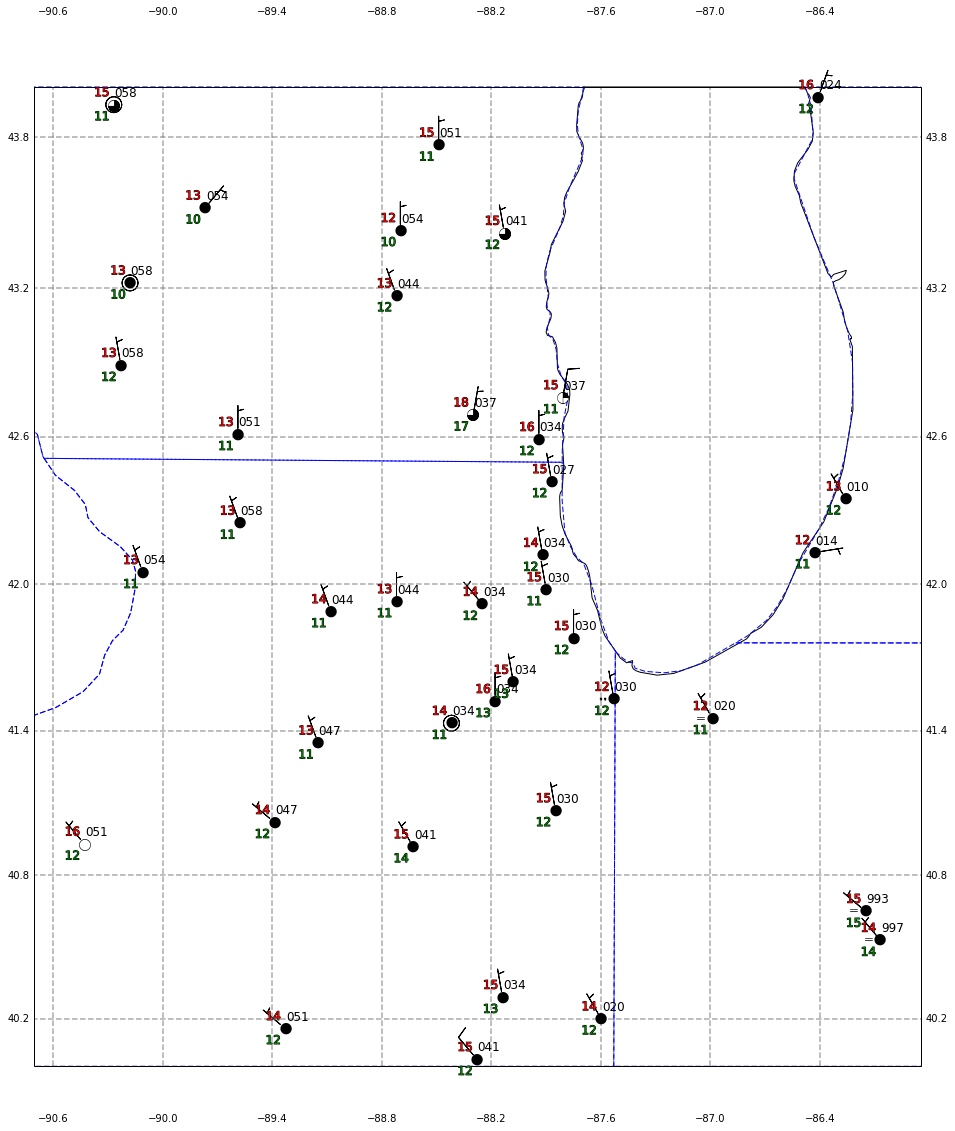

In [90]:

coast = cartopy.feature.NaturalEarthFeature(category='physical', scale='10m',
                            facecolor='none', name='lakes')

state_borders = cartopy.feature.NaturalEarthFeature(category='cultural',
    name='admin_1_states_provinces_lakes', scale='50m', facecolor='none') 

ax = radar_plus_obs(bb, datetime.utcnow(), station_radius=5000., station_layout=layout,
               figsize=figsize, timezone = None)
ax.add_feature(coast, facecolor='none', edgecolor='black')
ax.add_feature(cartopy.feature.BORDERS)
ax.add_feature(state_borders, linestyle="--", edgecolor='blue')
gl = ax.gridlines( draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')